# Time Series with XGBoost - COVID

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Import Data

In [2]:
with open('covid_data.p', 'rb') as f:
    data = pickle.load(f)

In [3]:
days_offset = 60

In [4]:
# Basic data cleanup
data = data[data.fips_code == '36047']
data = data.set_index('date')

data = data[['deaths_cdc','confirmed_cdc']]

max_date = data.index[-1].date().strftime('%Y-%m-%d')

#To create predicting the unknown records
tmp = pd.date_range(max_date, (data.index[-1].date() + timedelta(days=days_offset)).strftime('%Y-%m-%d'), freq='D')
tmp = pd.DataFrame(
    { 'deaths_cdc' : 0 , 'confirmed_cdc' : 0 }, 
    index=tmp)

#append tmp to data
data = data.append(tmp)

data['daily_deaths'] = data.deaths_cdc.diff()
data['3_day_ave'] =  data.daily_deaths.rolling(window=3).mean().shift(periods=days_offset)
data['5_day_ave'] =  data.daily_deaths.rolling(window=5).mean().shift(periods=days_offset)
data['7_day_ave'] =  data.daily_deaths.rolling(window=7).mean().shift(periods=days_offset)
data['14_day_ave'] =  data.daily_deaths.rolling(window=14).mean().shift(periods=days_offset)

data['daily_cases'] = data.confirmed_cdc.diff()
data['3_day_case_ave'] =  data.daily_cases.rolling(window=3).mean().shift(periods=days_offset)
data['5_day_case_ave'] =  data.daily_cases.rolling(window=5).mean().shift(periods=days_offset)
data['7_day_case_ave'] =  data.daily_cases.rolling(window=7).mean().shift(periods=days_offset)
data['14_day_case_ave'] =  data.daily_cases.rolling(window=14).mean().shift(periods=days_offset)

data['pred_deaths'] = data.daily_deaths.rolling(window=7).mean()

data.sort_index(inplace=True)
data = data.dropna()

# For debugging
df = pd.DataFrame(data)

# Remove back off the unknown records
data = data[data.index < max_date]

data.tail()

,deaths_cdc,confirmed_cdc,daily_deaths,3_day_ave,5_day_ave,7_day_ave,14_day_ave,daily_cases,3_day_case_ave,5_day_case_ave,7_day_case_ave,14_day_case_ave,pred_deaths
2021-01-10,7895.0,136485.0,17.0,2.333333,3.2,3.857143,3.642857,1522.0,381.333333,369.8,367.142857,313.500000,17.714286
2021-01-11,7914.0,137959.0,19.0,2.333333,2.8,3.714286,3.571429,1474.0,421.000000,390.0,381.000000,320.785714,18.714286
2021-01-12,7923.0,139672.0,9.0,1.666667,2.2,2.857143,3.214286,1713.0,472.666667,415.4,397.428571,336.571429,19.285714
2021-01-13,7941.0,141535.0,18.0,3.000000,2.8,3.000000,3.571429,1863.0,462.666667,440.2,412.571429,353.214286,19.142857
2021-01-14,7970.0,143078.0,29.0,3.000000,2.4,2.571429,3.428571,1543.0,454.333333,459.6,422.428571,366.642857,19.714286


## Split the data

In [5]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [6]:
train, test = split_data(data, (data.index[-1].date() - timedelta(days=days_offset)).strftime('%Y-%m-%d'))

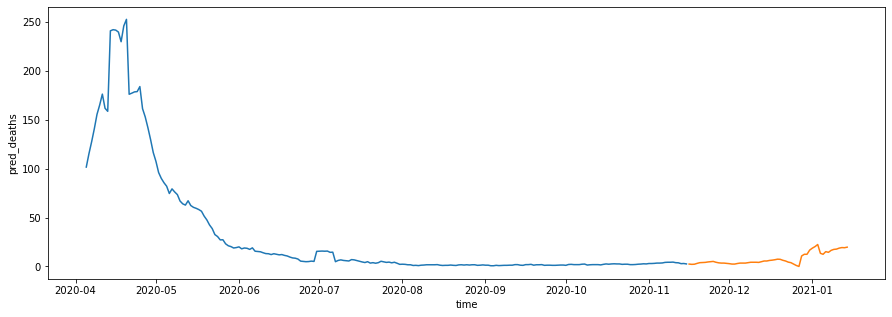

In [7]:
# Plot the train & test data
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('pred_deaths')
plt.plot(train.index,train["pred_deaths"])
plt.plot(test.index,test["pred_deaths"])
plt.show()

## Feature Engineering

In [8]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','3_day_ave', '5_day_ave',
            '7_day_ave',
            '14_day_ave',
            #'deaths_cdc', 
            #'confirmed_cdc',
            '3_day_case_ave', '5_day_case_ave','7_day_case_ave','14_day_case_ave',
            #'daily_deaths'
           ]]
    return X

In [9]:
X_train, y_train = create_features(train), train['pred_deaths']
X_test, y_test   = create_features(test), test['pred_deaths'] 

X_train.shape, y_train.shape

/home/james/.conda/envs/moby/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


((225, 16), (225,))

In [10]:
X_train.tail(3)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,3_day_ave,5_day_ave,7_day_ave,14_day_ave,3_day_case_ave,5_day_case_ave,7_day_case_ave,14_day_case_ave
2020-11-13,0,4,4,11,2020,318,13,46,2.333333,1.6,1.285714,1.142857,88.333333,91.0,82.000000,91.142857
2020-11-14,0,5,4,11,2020,319,14,46,0.000000,1.4,1.142857,1.142857,85.666667,90.4,89.142857,90.214286
2020-11-15,0,6,4,11,2020,320,15,46,1.666667,2.4,1.857143,1.500000,90.333333,91.8,92.714286,90.500000


## Train the Model

In [11]:
reg = xgb.XGBRegressor(
    n_estimators=10000,
    learning_rate=0.01,
    max_depth=6
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=10)

[0]	validation_0-rmse:65.30899	validation_1-rmse:8.96170
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:59.64113	validation_1-rmse:5.18400
[20]	validation_0-rmse:54.50684	validation_1-rmse:7.03352
[30]	validation_0-rmse:49.84656	validation_1-rmse:11.14256
[40]	validation_0-rmse:45.61479	validation_1-rmse:14.51837
[50]	validation_0-rmse:41.76492	validation_1-rmse:17.40149
[60]	validation_0-rmse:38.24503	validation_1-rmse:20.34260
Stopping. Best iteration:
[12]	validation_0-rmse:58.57389	validation_1-rmse:5.08820



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Performance Metrics

In [12]:
X_test_pred = reg.predict(X_test)

In [13]:
# Mean Squared Error
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

25.88976764351668

In [14]:
# Mean Absolute Error
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

4.165674162762506

## Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

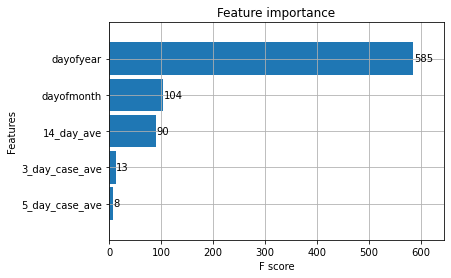

In [15]:
xgb.plot_importance(reg, height=0.9)

## Forecast on Test Data

In [16]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('average daily deaths')
    plt.plot(base_data.index, base_data, label='data')
    plt.plot(X_test.index, X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

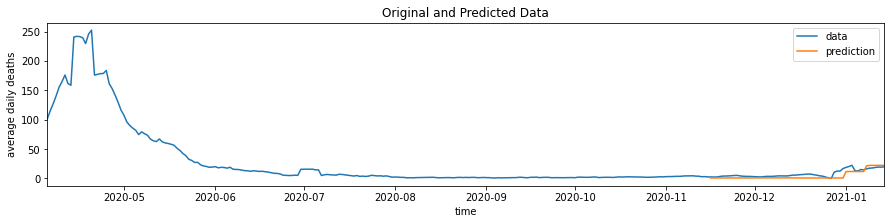

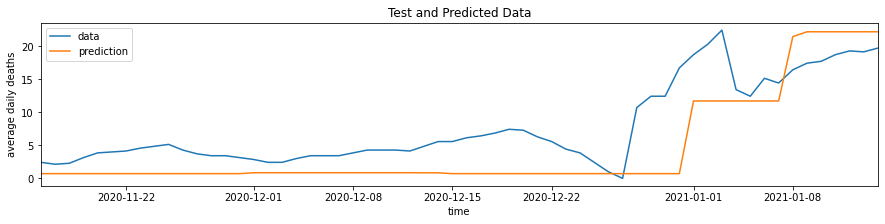

In [17]:
plot_performance(
    data["pred_deaths"], 
    data.index[0].date(), 
    data.index[-1].date(),
    'Original and Predicted Data'
)

plot_performance(
    y_test, 
    y_test.index[0].date(), 
    y_test.index[-1].date(),
    'Test and Predicted Data')

plt.legend()
plt.show()

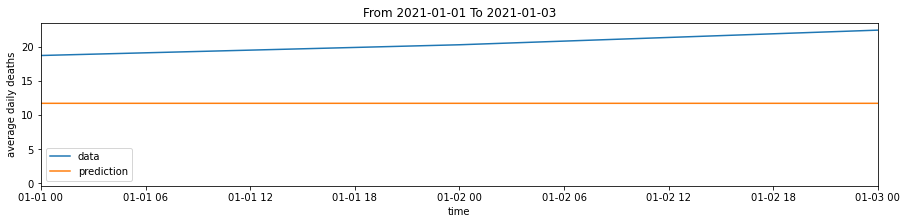

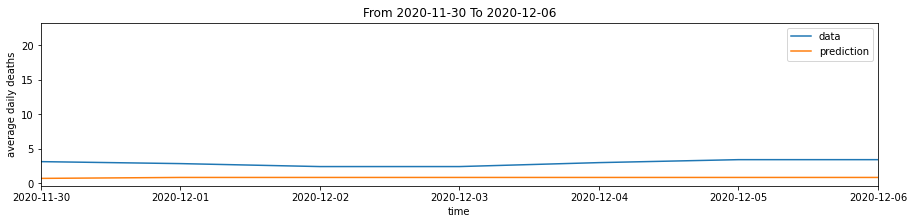

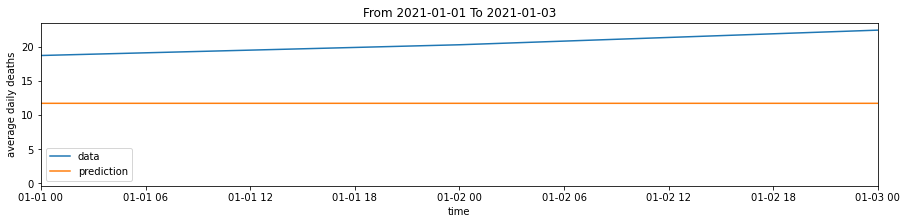

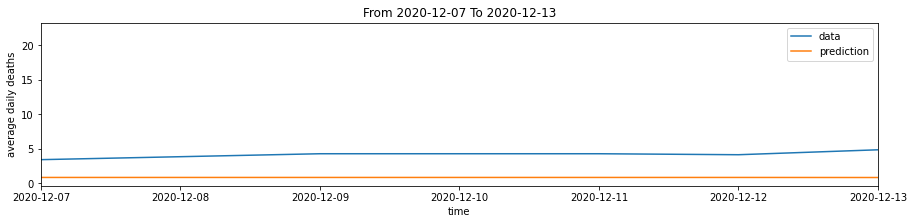

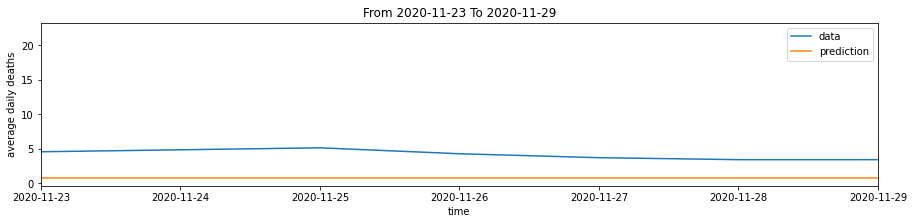

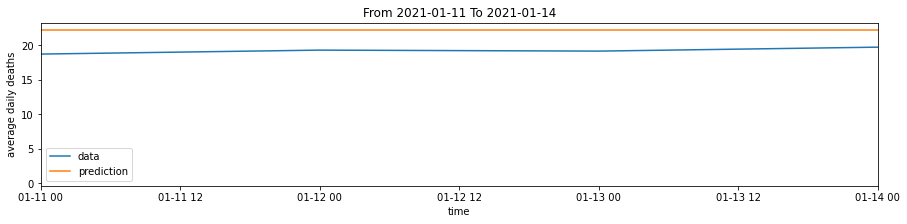

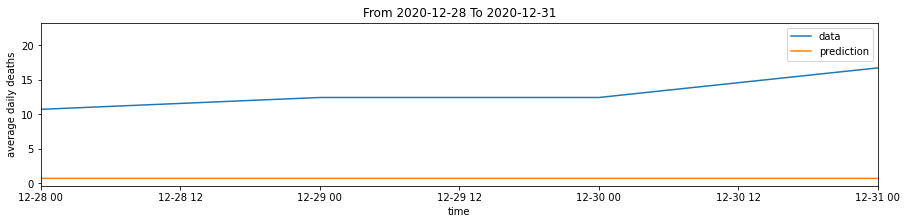

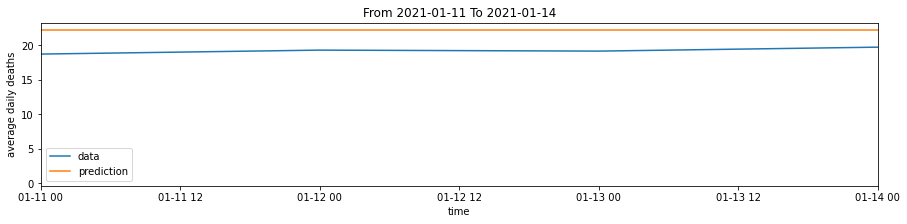

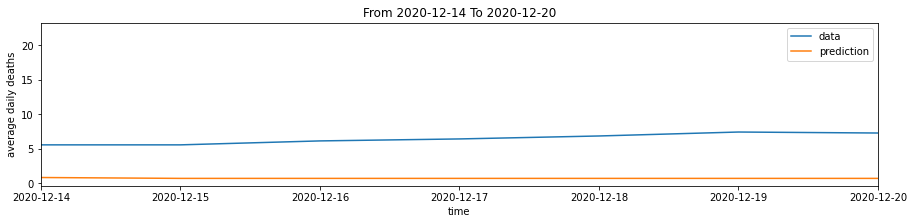

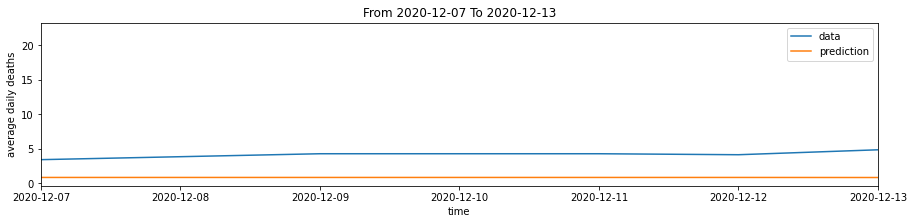

In [18]:
# Peformance for 10 random weeks 
random_weeks = X_test[['year', 'weekofyear']].sample(10)
for week in random_weeks.iterrows():
    index = (X_test.year == week[1].year) & \
            (X_test.weekofyear == week[1].weekofyear)
    tmp = y_test[index]
    plot_performance(tmp, tmp.index[0].date(), tmp.index[-1].date())

## Forecast the unknown

In [19]:
X_future = df[df.index >= max_date].copy()
X_future = create_features(X_future)
X_future_pred = reg.predict(X_future)

/home/james/.conda/envs/moby/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


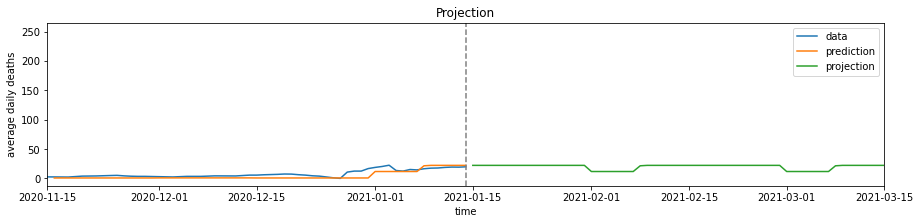

In [20]:
plot_performance(
    data["pred_deaths"], 
    data.index[-1].date() - timedelta(days=days_offset), 
    data.index[-1].date() + timedelta(days=days_offset),
    'Projection'
)

plt.plot(X_future.index, X_future_pred, label='projection')
plt.axvline(x=data.index[-1].date(), color='grey', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# Need to seed some earlier dates so longer projection periods do not truncate early data
# Add holidays
# Add predicting a given county using another counties rates
# Try predicting cumulative, or cumulative per 100k